**Multiclass classifier**

In [ ]:
# Dataset

from google.colab import drive
from sklearn.datasets import load_files

drive.mount("/content/drive")

# Raw data (BCC article datasets) obtained from the Insight Project
# http://mlg.ucd.ie/datasets/bbc.html
loaded_data = load_files("/content/drive/My Drive/data/bbc")

raw_dataset, y, y_names = loaded_data.data, loaded_data.target, loaded_data.target_names

print("Number of documents in the dataset:", len(raw_dataset))
print("Labels (automatically generated from subfolder names):")
for label in y_names:
  print("\t", label)

Mounted at /content/drive
Number of documents in the dataset: 2225
Labels (automatically generated from subfolder names):
	 business
	 entertainment
	 politics
	 sport
	 tech


In [ ]:
# Text preprocessing

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

dataset = []
stemmer = SnowballStemmer("english")
stopwords_en = stopwords.words("english")

for i in range(0, len(raw_dataset)):  
  tokens = regexp_tokenize(str(raw_dataset[i]), r"\w+")
  stems = [stemmer.stem(token) for token in tokens]
  words_no_stopwords = [word for word in stems if word not in stopwords_en]
  document = ' '.join(words_no_stopwords)
  dataset.append(document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Feature extraction (converting text to vectors)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset).toarray()

In [ ]:
# Split training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Create model

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(len(y_names), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 50)                1128850   
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 255       
Total params: 1,129,105
Trainable params: 1,129,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model

history = model.fit(X_train, y_train, epochs=30, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [ ]:
# Evaluate model

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9730


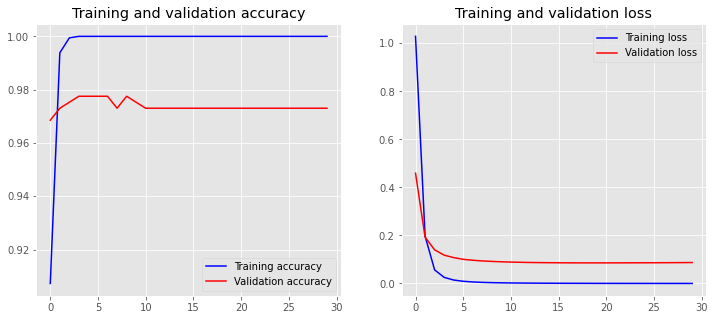

In [ ]:
# Plot loss and accuracy for the training and testing data 

import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(0, len(acc))
  
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training accuracy')
  plt.plot(x, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

plot_history(history)

In [ ]:
# Predict unseen data

import numpy as np

unseen_sentence = input("Enter a sentence: ")
X_unseen = vectorizer.transform([unseen_sentence]).toarray()
y_unseen = np.argmax(model.predict(X_unseen), axis=-1) # Equivalent to: y_unseen = model.predict_classes(X_unseen)

print("Possible classes:", y_names)
print("The pedicted class for that sentence is:", y_names[y_unseen[0]])

Enter a sentence: Messi scores a goal
Possible classes: ['business', 'entertainment', 'politics', 'sport', 'tech']
The pedicted class for that sentence is: sport


In [ ]:
# Savel model

import h5py

model_structure = model.to_json()

with open("multiclass_classifier_model.json", "w") as json_file:
  json_file.write(model_structure)

model.save_weights("multiclass_classifier_weights.h5")